# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# Chapitre 7 : Mélange de lois

Dans ce chapitre, nous utiliserons le jeu de données *Galton.csv* disponible sur le site web du cours. Dans les années 1880, Francis Galton a recueilli des données sur la taille des enfants en fonction de la taille des parents. La description de ce jeu de donnée est fournie dans la cellule suivante. Nous n'utiliserons que le sexe et la taille des individus dans ce chapitre pour illustrer les concepts de ce chapitre.



<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd"><html xmlns="http://www.w3.org/1999/xhtml"><head><title>R: Galton's dataset of parent and child heights</title>
<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
<link rel="stylesheet" type="text/css" href="R.css" />
</head><body>


<h2>Galton's dataset of parent and child heights</h2>

<h3>Description</h3>

<p>In the 1880's, Francis Galton was developing ways to quantify the
heritability of traits.  As part of this work, he collected data on
the heights of adult children and their parents.
</p>


<h3>Format</h3>

<p>A data frame with 898 observations on the following variables.
</p>

<ul>
<li><p><code>family</code> a factor with levels for each family
</p>
</li>
<li><p><code>father</code> the father's height (in inches)
</p>
</li>
<li><p><code>mother</code> the mother's height (in inches)
</p>
</li>
<li><p><code>sex</code> the child's sex: <code>F</code> or <code>M</code>
</p>
</li>
<li><p><code>height</code> the child's height as an adult (in inches)
</p>
</li>
<li><p><code>nkids</code> the number of adult children in the family, or, at least,
the number whose heights Galton recorded.
</p>
</li></ul>


<h3>Details</h3>

<p>Entries were deleted for
those children whose heights were not recorded numerically by Galton,
who sometimes used entries such as "tall", "short", "idiotic", "deformed" and so on.
</p>


<h3>Source</h3>

<p>The data were transcribed by J.A. Hanley who has published them at
<a href="http://www.medicine.mcgill.ca/epidemiology/hanley/galton/">http://www.medicine.mcgill.ca/epidemiology/hanley/galton/</a>
</p>


<h3>References</h3>

<p>&quot;Transmuting&quot; women into men: Galton's family data on human stature. (2004)
<em>The American Statistician</em>, 58(3):237-243.
</p>



</body></html>


In [1]:
# Chargement deslibrairies nécessaires

using CSV, DataFrames, Statistics, Gadfly, Distributions, Random

In [2]:
# functions utiles

function GMM(ω::Real, μ₀::Real, σ₀::Real, μ₁::Real, σ₁::Real)
    
    pd = MixtureModel(Normal[ Normal(μ₀, σ₀), Normal(μ₁, σ₁)], [1-ω, ω])
    
    return pd
    
end

function _emstep(pd::MixtureModel,y)
    
    n = length(y)
    
    f₁ = component(pd, 2)
    ω = probs(pd)[2]
    
    lp₁ = log(ω) .+ logpdf.(f₁,y) - logpdf.(pd, y)
    p₁ = exp.(lp₁)
    
    ω̂ = sum(p₁)/n
    
    p₀ = 1 .- p₁
    
    μ̂₀ = sum( p₀.* y) / sum(p₀)
    
    σ̂₀² = sum( p₀.* (y .- μ̂₀).^2 ) / sum(p₀)
    
    μ̂₁ = sum( p₁.* y) / sum(p₁)
    
    σ̂₁² = sum( p₁.* (y .- μ̂₁).^2 ) / sum(p₁)
    
    fd = GMM(ω̂, μ̂₀, sqrt(σ̂₀²), μ̂₁, sqrt(σ̂₁²))
    
    return fd
    
end

function GMMemfit(y::Vector{<:Real} ; initialValue::Vector{<:Real}=Float64[], maxiter::Int=1000, tol::Real=2*eps())
    
    if isempty(initialValue)
        
        ind = (1:n) .< n/2
        
        y₀ = y[ind]
        y₁ = y[.!(ind)]
        
        initialValue = [.5, mean(y₀), std(y₀), mean(y₁), std(y₁)]
        
    end
    
    pd = GMM(initialValue...)
    
    iter = 1
    err = 1
    
    while (err > tol) & (iter < maxiter)
       
        fd = _emstep(pd,y)
        
        err = abs(loglikelihood(fd,y) - loglikelihood(pd,y))
        
        pd = fd
        
        iter +=1
        
    end
    
    if iter>maxiter
        println("Convergence not reached in $maxiter iterations")
    else
        println("Convergence reached in $iter iterations")
    end
    
 return pd
    
end


GMMemfit (generic function with 1 method)

## Analyse exploratoire

In [3]:
data = CSV.read("Galton.csv")
select!(data, [:sex, :height])
first(data,5)

,sex,height
,String,Float64
1,M,73.2
2,F,69.2
3,F,69.0
4,F,69.0
5,M,73.5


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping(::DataFrame, ::Symbol) at dataframes.jl:96
└ @ Gadfly C:\Users\7amdi\.julia\packages\Gadfly\1wgcD\src\dataframes.jl:96


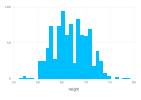

In [4]:
# Histogramme des données

n = size(data,1)

nbin = Int64(floor(sqrt(n)))

plot(data, x=:height, Geom.histogram(bincount = nbin))

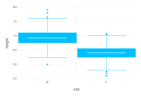

In [5]:
# Diagramme en boïte des tailles en fonction du sexe

plot(data, x=:sex, y=:height, Geom.boxplot)

Convergence reached in 833 iterations


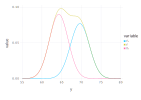

In [6]:
y = data[:,:height]

fd = GMMemfit(y)

f₀= component(fd, 1)
f₁ = component(fd, 2)
ω = probs(fd)[2]

if mean(f₀)>mean(f₁)
    f₁ = component(fd, 1)
    f₀ = component(fd, 2)
    ω = probs(fd)[1]
    
    fd = GMM(ω,mean(f₀),std(f₀),mean(f₁),std(f₁))
end    

x = 55:.01:80

df = DataFrame(y = x, f₁ = ω*pdf.(f₁,x), f = pdf.(fd,x), f₀ = (1-ω)*pdf.(f₀,x))

df = melt(df, :y) 

plot(df, x=:y, y=:value, color=:variable, Geom.line)

In [7]:
lp = log(probs(fd)[2]) .+ logpdf.(component(fd, 2),y) - logpdf.(fd,y)

ind = lp .> log(.5)

pM = count(data[ind,:sex].=="M")/count(data[:,:sex].=="M")
println("Proportion d'hommes bien identifiés = $pM")

ind = lp .< log(.5)

pF = count(data[ind,:sex].=="F")/count(data[:,:sex].=="F")
println("Proportion de femmes bien identifiées = $pF")

Proportion d'hommes bien identifiés = 0.7569892473118279
Proportion de femmes bien identifiées = 0.9076212471131639


## Estimation bayésienne avec loi *a priori* non informative

In [8]:
niter = 1000

# initialisation des vecteurs
θ = zeros(5,niter)
z = falses(n,niter)



# valeurs initiales arbitraires
z[:,1] = (1:n) .< n/2

        
y₀ = y[z[:,1]]
y₁ = y[.!(z[:,1])]
        
θ[1,1] = .5
θ[2,1] =  mean(y₀)
θ[3,1] =  std(y₀)
θ[4,1] =  mean(y₁)
θ[5,1] =  std(y₁)

pd = GMM(θ[:,1]...)


u = rand(n)


# Échantillonnage de Gibbs
for i=2:niter
   
    f₀ = component(pd,1)
    f₁ = component(pd,2)
    
    lp = log(probs(pd)[2]) .+ logpdf.(f₁,y) .- logpdf.(pd, y)

    rand!(u)

    z[:,i] = lp .> log.(u)
    
    n₁ = count(z[:,i])
    n₀ = n - n₁
    
    y₀ = y[.!(z[:,i])]
    y₁ = y[z[:,i]]
    
    ȳ₀ = mean(y₀)
    ȳ₁ = mean(y₁)
       
    θ[1,i] = rand(Beta(n₁, n₀))
    
    θ[2,i] = rand(Normal(ȳ₀, std(f₀)/sqrt(n₀)))
    
    b = sum( (y₀ .- θ[2,i]).^2 )
    θ[3,i] = sqrt( rand(InverseGamma(n₀/2,b/2)) )
    
    θ[4,i] = rand(Normal(ȳ₁, std(f₁)/sqrt(n₁)))
    
    b = sum( (y₁ .- θ[4,i]).^2 )
    θ[5,i] = sqrt( rand(InverseGamma(n₁/2,b/2)) )
    
    pd = GMM(θ[:,i]...)
        
end

mcmc = convert(DataFrame, θ')
mcmc[!,:Itération] = 1:size(mcmc,1)
permutecols!(mcmc, [6;1:5])
rename!(mcmc, :x1 => :ω, :x2 => :μ₀, :x3 => :σ₀ , :x4 => :μ₁, :x5 => :σ₁)

first(mcmc,5)

,Itération,ω,μ₀,σ₀,μ₁,σ₁
,Int64,Float64,Float64,Float64,Float64,Float64
1,1,0.5,67.6357,3.5275,65.8896,3.42545
2,2,0.511235,67.8645,3.62572,65.5649,3.30748
3,3,0.490882,67.6872,3.43862,65.7253,3.41533
4,4,0.515713,67.7513,3.60425,65.6563,3.44691
5,5,0.449619,67.7293,3.55351,65.6699,3.24571


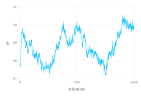

In [9]:
plot(mcmc, x=:Itération, y=:μ₀, Geom.line)

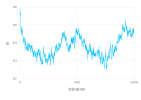

In [10]:
plot(mcmc, x=:Itération, y=:μ₁, Geom.line)

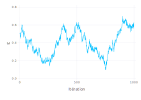

In [11]:
plot(mcmc, x=:Itération, y=:ω, Geom.line)

## Estimation avec algorithme EM

In [12]:
pd = GMM(.5,50,3,80,3)

MixtureModel{Normal}(K = 2)
components[1] (prior = 0.5000): Normal{Float64}(μ=50.0, σ=3.0)
components[2] (prior = 0.5000): Normal{Float64}(μ=80.0, σ=3.0)


In [13]:
df = DataFrame(Itération = Int64[], ω = Float64[], μ₀ = Float64[], σ₀ = Float64[], μ₁ = Float64[], σ₁ = Float64[])


ω = probs(pd)[2]
μ₀ = mean(component(pd, 1))
σ₀ = std(component(pd, 1))
μ₁ = mean(component(pd, 2))
σ₁ = std(component(pd, 2))

push!(df, [1, ω, μ₀, σ₀, μ₁, σ₁])

for i=2:1000
    pd = _emstep(pd,y)
    
    ω = probs(pd)[2]
    μ₀ = mean(component(pd, 1))
    σ₀ = std(component(pd, 1))
    μ₁ = mean(component(pd, 2))
    σ₁ = std(component(pd, 2))
    
    push!(df, [i, ω, μ₀, σ₀, μ₁, σ₁])
end


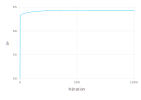

In [14]:
plot(df, x=:Itération, y=:μ₀, Geom.line)

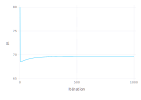

In [15]:
plot(df, x=:Itération, y=:μ₁, Geom.line)

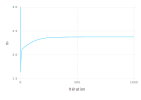

In [16]:
plot(df, x=:Itération, y=:σ₀, Geom.line)

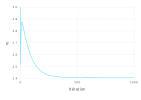

In [17]:
plot(df, x=:Itération, y=:σ₁, Geom.line)

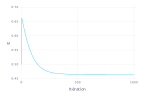

In [18]:
plot(df, x=:Itération, y=:ω, Geom.line)